### Packages

In [1]:
import findspark
findspark.init()

In [2]:
# Spark / Sql
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, FloatType
from pyspark.sql.functions import col

In [3]:
# Spark ML
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression

In [4]:
# Others
import pandas as pd
%matplotlib inline

### SparkContext

In [5]:
sc = SparkContext(master="local[4]")
sqc = SQLContext(sc)

### Load data (txt file)

In [6]:
# This notebook is inspired from https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning
# Data on this link is from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

In [7]:
!ls data/CaliforniaHousing/

cal_housing.data  cal_housing.domain


In [8]:
data_rdd = sc.textFile('data/CaliforniaHousing/cal_housing.data')
header_rdd = sc.textFile('data/CaliforniaHousing/cal_housing.domain')

In [9]:
header_rdd.collect()

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

In [10]:
data_rdd.take(2)

['-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000',
 '-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000']

In [11]:
data_rdd1 = data_rdd.map(lambda txt: txt.split(","))
data_rdd1.take(2)

[['-122.230000',
  '37.880000',
  '41.000000',
  '880.000000',
  '129.000000',
  '322.000000',
  '126.000000',
  '8.325200',
  '452600.000000'],
 ['-122.220000',
  '37.860000',
  '21.000000',
  '7099.000000',
  '1106.000000',
  '2401.000000',
  '1138.000000',
  '8.301400',
  '358500.000000']]

### Convert RDD to Dataframe

In [12]:
# Use RDD for low level transformations on unstructured data
# Use DF for performance benefits on semi/structured data, high level expressions, sql queries, columnar access.

In [13]:
# Map each line to row type with Schema
data_rdd2 = data_rdd1.map(lambda row: Row(longitude = row[0] ,
                                            latitude = row[1] ,
                                            housingMedianAge = row[2] ,
                                            totalRooms = row[3]  ,
                                            totalBedrooms = row[4]  ,
                                            population = row[5]  ,
                                            households = row[6]  ,
                                            medianIncome = row[7]  ,
                                            medianHouseValue = row[8]))

In [14]:
# Convert to dataframe
data_df = data_rdd2.toDF()

In [15]:
# View df
data_df.show()
data_df.columns

+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| households|housingMedianAge| latitude|  longitude|medianHouseValue|medianIncome| population|totalBedrooms| totalRooms|
+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| 126.000000|       41.000000|37.880000|-122.230000|   452600.000000|    8.325200| 322.000000|   129.000000| 880.000000|
|1138.000000|       21.000000|37.860000|-122.220000|   358500.000000|    8.301400|2401.000000|  1106.000000|7099.000000|
| 177.000000|       52.000000|37.850000|-122.240000|   352100.000000|    7.257400| 496.000000|   190.000000|1467.000000|
| 219.000000|       52.000000|37.850000|-122.250000|   341300.000000|    5.643100| 558.000000|   235.000000|1274.000000|
| 259.000000|       52.000000|37.850000|-122.250000|   342200.000000|    3.846200| 565.000000|   280.000000|1627.000000|
| 193.000000|       52.000000|37

['households',
 'housingMedianAge',
 'latitude',
 'longitude',
 'medianHouseValue',
 'medianIncome',
 'population',
 'totalBedrooms',
 'totalRooms']

In [16]:
# View df data types
print(data_df.dtypes)
data_df.printSchema()

[('households', 'string'), ('housingMedianAge', 'string'), ('latitude', 'string'), ('longitude', 'string'), ('medianHouseValue', 'string'), ('medianIncome', 'string'), ('population', 'string'), ('totalBedrooms', 'string'), ('totalRooms', 'string')]
root
 |-- households: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- population: string (nullable = true)
 |-- totalBedrooms: string (nullable = true)
 |-- totalRooms: string (nullable = true)



In [17]:
# Convert df data types to float
columns = ['households', 'housingMedianAge', 
           'latitude', 'longitude', 
           'medianHouseValue', 'medianIncome', 
           'population', 'totalBedRooms', 'totalRooms']
for col in columns:
    data_df = data_df.withColumn(col, data_df[col].cast(FloatType()))

# View df data types
print(data_df.dtypes)
data_df.printSchema()

[('households', 'float'), ('housingMedianAge', 'float'), ('latitude', 'float'), ('longitude', 'float'), ('medianHouseValue', 'float'), ('medianIncome', 'float'), ('population', 'float'), ('totalBedRooms', 'float'), ('totalRooms', 'float')]
root
 |-- households: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- population: float (nullable = true)
 |-- totalBedRooms: float (nullable = true)
 |-- totalRooms: float (nullable = true)



### Explore data

Features:
- Longitude of block group
- Latitude of block group
- Housing median age is median age of people in block group 
- Total rooms in the houses in block group
- Total bedrooms in the houses in block group
- Population of inhabitants in block group
- Households is number of houses or occupants in block group
- Median income of people in block group 

Target variable:
- Median house value of block group

In [18]:
data_df.columns

['households',
 'housingMedianAge',
 'latitude',
 'longitude',
 'medianHouseValue',
 'medianIncome',
 'population',
 'totalBedRooms',
 'totalRooms']

In [19]:
# simple select
data_df.select('population','totalRooms').show(5)

+----------+----------+
|population|totalRooms|
+----------+----------+
|     322.0|     880.0|
|    2401.0|    7099.0|
|     496.0|    1467.0|
|     558.0|    1274.0|
|     565.0|    1627.0|
+----------+----------+
only showing top 5 rows



+----------+-----+
|households|count|
+----------+-----+
|    6082.0|    1|
|    5358.0|    1|
|    5189.0|    1|
|    5050.0|    1|
|    4930.0|    1|
+----------+-----+
only showing top 5 rows



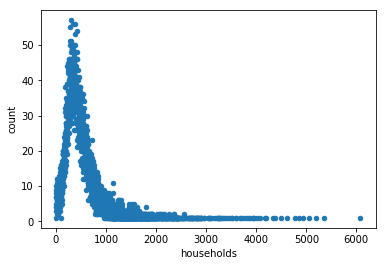

In [20]:
# more complex queries
data_df.groupBy('households').count().sort('households',ascending=False).show(5)
data_df_pd  = data_df.groupBy('households').count().toPandas()
data_df_pd.plot.scatter('households','count')

In [21]:
# Check feature ranges - normalize or not?
data_df.describe(columns[0:4]).show()
data_df.describe(columns[4:10]).show()

+-------+------------------+------------------+------------------+-------------------+
|summary|        households|  housingMedianAge|          latitude|          longitude|
+-------+------------------+------------------+------------------+-------------------+
|  count|             20640|             20640|             20640|              20640|
|   mean| 499.5396802325581|28.639486434108527| 35.63186143109965|-119.56970444871473|
| stddev|382.32975283161136|12.585557612111613|2.1359523806029554| 2.0035317429328914|
|    min|               1.0|               1.0|             32.54|            -124.35|
|    max|            6082.0|              52.0|             41.95|            -114.31|
+-------+------------------+------------------+------------------+-------------------+

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|  medianHouseValue|      medianIncome|        population|    totalBedRooms|        totalRooms|
+-------

### Data processing - editing dataframe

In [22]:
from pyspark.sql.functions import col

In [23]:
# Reduce range of medianhousevalue i.e. y
data_df = data_df.withColumn('medianHouseValue', col('medianHouseValue')/10000)
data_df.describe('medianHouseValue').show()

+-------+------------------+
|summary|  medianHouseValue|
+-------+------------------+
|  count|             20640|
|   mean|20.685581690891706|
| stddev|11.539561587441375|
|    min|            1.4999|
|    max|           50.0001|
+-------+------------------+



In [24]:
# Create new features from existing columns
feature1_df = data_df.select(col('totalRooms')/col('households'))
feature1_df.show(5)
type(feature1_df)

+-------------------------+
|(totalRooms / households)|
+-------------------------+
|        6.984126984126984|
|        6.238137082601054|
|        8.288135593220339|
|       5.8173515981735155|
|        6.281853281853282|
+-------------------------+
only showing top 5 rows



pyspark.sql.dataframe.DataFrame

In [25]:
# Add new features
data_df = data_df.withColumn('roomsperhousehold', col('totalRooms')/col('households'))\
                  .withColumn('populationperhousehold', col('population')/col('households'))\
                  .withColumn('bedroomsperroom', col('totalBedRooms')/col('totalRooms'))
data_df.columns

['households',
 'housingMedianAge',
 'latitude',
 'longitude',
 'medianHouseValue',
 'medianIncome',
 'population',
 'totalBedRooms',
 'totalRooms',
 'roomsperhousehold',
 'populationperhousehold',
 'bedroomsperroom']

In [26]:
# Check feature ranges - normalize or not?
columns = data_df.columns
i = 0
while i < len(columns):
    e = i+4 if i+4 <= len(columns) else len(columns)
    data_df.describe(columns[i:e]).show()
    i+=4

+-------+------------------+------------------+------------------+-------------------+
|summary|        households|  housingMedianAge|          latitude|          longitude|
+-------+------------------+------------------+------------------+-------------------+
|  count|             20640|             20640|             20640|              20640|
|   mean| 499.5396802325581|28.639486434108527| 35.63186143109965|-119.56970444871473|
| stddev|382.32975283161136|12.585557612111613|2.1359523806029554| 2.0035317429328914|
|    min|               1.0|               1.0|             32.54|            -124.35|
|    max|            6082.0|              52.0|             41.95|            -114.31|
+-------+------------------+------------------+------------------+-------------------+

+-------+------------------+------------------+------------------+-----------------+
|summary|  medianHouseValue|      medianIncome|        population|    totalBedRooms|
+-------+------------------+------------------

In [27]:
# Re-order columns and drop longitude, latitude
columns = ['medianHouseValue',
            'households',
             'housingMedianAge',             
             'medianIncome',
             'population',
             'totalBedRooms',
             'totalRooms',
             'roomsperhousehold',
             'populationperhousehold',
             'bedroomsperroom']
data_df = data_df.select(columns)
data_df.columns

['medianHouseValue',
 'households',
 'housingMedianAge',
 'medianIncome',
 'population',
 'totalBedRooms',
 'totalRooms',
 'roomsperhousehold',
 'populationperhousehold',
 'bedroomsperroom']

In [28]:
# Separate df into features and label

# Create new RDD using RDD and map with key, value pairs -> label, features
data_rdd_new = data_df.rdd.map( lambda row: (row[0], DenseVector(row[1:])) )

# Create dataframe with this RDD new column names
column_names = ["label", "features"]
data_df_new = sqc.createDataFrame(data_rdd_new, column_names)

In [29]:
# View new rdd and df
print(data_rdd_new.take(5))
data_df_new.show(5)

[(45.26, DenseVector([126.0, 41.0, 8.3252, 322.0, 129.0, 880.0, 6.9841, 2.5556, 0.1466])), (35.85, DenseVector([1138.0, 21.0, 8.3014, 2401.0, 1106.0, 7099.0, 6.2381, 2.1098, 0.1558])), (35.21, DenseVector([177.0, 52.0, 7.2574, 496.0, 190.0, 1467.0, 8.2881, 2.8023, 0.1295])), (34.13, DenseVector([219.0, 52.0, 5.6431, 558.0, 235.0, 1274.0, 5.8174, 2.5479, 0.1845])), (34.22, DenseVector([259.0, 52.0, 3.8462, 565.0, 280.0, 1627.0, 6.2819, 2.1815, 0.1721]))]
+-----+--------------------+
|label|            features|
+-----+--------------------+
|45.26|[126.0,41.0,8.325...|
|35.85|[1138.0,21.0,8.30...|
|35.21|[177.0,52.0,7.257...|
|34.13|[219.0,52.0,5.643...|
|34.22|[259.0,52.0,3.846...|
+-----+--------------------+
only showing top 5 rows



In [30]:
# Normalize data
SS = StandardScaler(inputCol="features", outputCol="features_scaled")
SSf = SS.fit(data_df_new)
data_df_new_scaled = SSf.transform(data_df_new)
data_df_new_scaled.show(5)

+-----+--------------------+--------------------+
|label|            features|     features_scaled|
+-----+--------------------+--------------------+
|45.26|[126.0,41.0,8.325...|[0.32955844808524...|
|35.85|[1138.0,21.0,8.30...|[2.97648820572226...|
|35.21|[177.0,52.0,7.257...|[0.46295115326260...|
|34.13|[219.0,52.0,5.643...|[0.57280396929101...|
|34.22|[259.0,52.0,3.846...|[0.67742569884188...|
+-----+--------------------+--------------------+
only showing top 5 rows



### Model

In [31]:
# Split into train and test set
train_df, test_df = data_df_new_scaled.randomSplit([.8,.2],seed=1)

In [32]:
train_df.count(), test_df.count()

(16504, 4136)

In [33]:
# Fit train data
LR = LinearRegression(labelCol="label", maxIter=100, regParam=0.1, elasticNetParam=0.8)
LR_model = LR.fit(train_df)

In [34]:
# Get train error, coefficients
print(LR_model.coefficients)
print(LR_model.intercept)
print(LR_model.summary.r2)
print(LR_model.summary.rootMeanSquaredError)

[0.0106656552036,0.170060500902,4.9732786428,-0.00298231635751,0.0,0.0,0.0,-0.0159912839872,40.7779179754]
-13.202170357298824
0.5817341259754492
7.426464280169096


In [35]:
# Predict test labels
pred_df = LR_model.transform(test_df)
type(pred_df)

pyspark.sql.dataframe.DataFrame

In [36]:
# View predictions and true label
pred_df.select('prediction').show(5)
pred_df.select('label').show(5)

+------------------+
|        prediction|
+------------------+
|15.742991247459665|
|18.972070130328206|
|13.737591604700286|
|19.767692629790417|
|  9.22443934940914|
+------------------+
only showing top 5 rows

+-----+
|label|
+-----+
| 2.25|
| 3.25|
| 3.75|
| 3.88|
| 3.94|
+-----+
only showing top 5 rows



In [37]:
# Extract and zip preds and labels together
pred_rdd = pred_df.select('prediction').rdd.map(lambda row: row[0])
true_label_rdd = pred_df.select('label').rdd.map(lambda row: row[0])
pred_true_labels = pred_rdd.zip(true_label_rdd).collect()
pred_true_labels[0:5], len(pred_true_labels)

([(15.742991247459665, 2.25),
  (18.972070130328206, 3.25),
  (13.737591604700286, 3.75),
  (19.767692629790417, 3.88),
  (9.22443934940914, 3.94)],
 4136)